In [ ]:
#!unzip Applied_ML_Assignment_Images.zip

In [ ]:
!pip install -r ./requirements.txt

In [4]:
#Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from collections import namedtuple
from torch import nn
from torch.utils import model_zoo
from iglovikov_helper_functions.dl.pytorch.utils import rename_layers
from segmentation_models_pytorch import Unet
model = namedtuple("model", ["url", "model"])

In [2]:
# Dictionary containing the pre-trained model and its corresponding URL
models = {
    "Unet_2024-08-12": model(
        url="https://shorturl.at/TUWGv",
        model=Unet(encoder_name="timm-efficientnet-b3", classes=1, encoder_weights=None),
    )
}


def create_model(model_name: str) -> nn.Module:
    """
    Function to load a pre-trained model.

    Args:
        model_name (str): Name of the model to load.

    Returns:
        nn.Module: The loaded model with pre-trained weights.
    """
    model = models[model_name]['model']
    # Load the pre-trained weights
    state_dict = model_zoo(models[model_name]['url'], progress=True, map_location="cpu")["state_dict"]
    # Rename layers if necessary to match the architecture
    state_dict = rename_layers(state_dict, {"model.": ""})
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    return model

In [25]:
# Load the pre-trained U-Net model and set it to evaluation mode
model = create_model("Unet_2024-08-12")
model.to('cuda')  # Using GPU for faster inference
model.eval()

def main(image_paths):
    """
    Main function to process images, generate masks, and save the results.

    Args:
        image_paths (list): List of image paths to process.
    """
    for image_path in image_paths:
        # Load the image in RGB format
        image = load_rgb(image_path)
        #imshow(image)  # Display the input image

        # Define the transformation (Normalization)
        transform = albu.Compose([albu.Normalize(p=1)], p=1)

        # Pad the image to ensure compatibility with the model's input size
        padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

        # Apply the transformation and convert the image to a tensor
        x = transform(image=padded_image)["image"]
        x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

        # Perform inference using the pre-trained model
        with torch.no_grad():
            prediction = model(x.to('cuda'))[0][0]

        # Convert the prediction to a binary mask (1 for garment, 0 for background)
        mask = (prediction > 0).cpu().numpy().astype(np.uint8)
        # Remove the padding to restore the original image size
        mask = unpad(mask, pads)
        #imshow(mask)  # Display the binary mask

        # Optionally, overlay the mask on the original image for visualization
        dst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0)
        imshow(np.hstack([image, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255, dst]))

        # Save the binary mask with the appropriate filename
        mask_output_path = os.path.splitext(image_path)[0] + '_mask' + os.path.splitext(image_path)[1]
        cv2.imwrite(mask_output_path, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255)

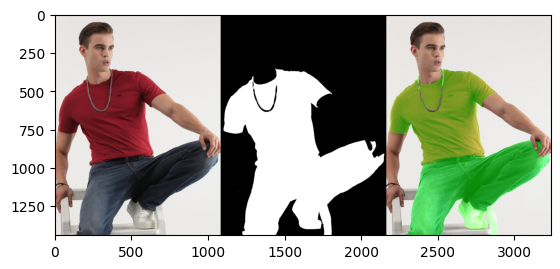

In [36]:
# List of image paths to process
if __name__ == "__main__":
    image_paths = ['./Applied ML Assignment Images/image_10.jpeg']# Add more paths as needed
    main(image_paths)

In [ ]:
#!zip -r /content/finished_ML_Assignment_Images.zip '/content/Applied ML Assignment Images'

In [20]:
#!pip freeze > requirements.txt

In [16]:
#! rm -r '/content/Applied ML Assignment Images'